In [1]:
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement
import pyarrow as pa
import csv
import subprocess

cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.12:3.1.0 pyspark-shell'

#spark = SparkSession.builder.appName('SparkCassandraApp').master("local[*]").getOrCreate()
import warnings
warnings.filterwarnings('ignore')

In [2]:
KeyspaceName = 'ukrainetweets'
TableName = 'RawTweet'
session.set_keyspace(KeyspaceName)
#session.execute(f'DROP TABLE {TableName}')

In [3]:
import os
import csv
import gzip
from cassandra.cluster import Cluster
import pandas as pd


ReplicationOptions = {'class': 'SimpleStrategy', 'replication_factor': 1}

query = f"CREATE KEYSPACE IF NOT EXISTS {KeyspaceName} WITH REPLICATION = {ReplicationOptions}"
session.execute(query)

TableName = 'RawTweet'
ColumnNames = ["num", "userid","username","acctdesc","location","following","followers","totaltweets","usercreatedts","tweetid","tweetcreatedts","retweetcount","text","hashtags","language","coordinates","favorite_count","is_retweet","original_tweet_id","original_tweet_userid","original_tweet_username","in_reply_to_status_id","in_reply_to_user_id","in_reply_to_screen_name","is_quote_status","quoted_status_id","quoted_status_userid","quoted_status_username","extractedts"]

create_table = f"CREATE TABLE IF NOT EXISTS {KeyspaceName}.{TableName} (num TEXT, userid TEXT, username TEXT, acctdesc TEXT, location TEXT, following TEXT, followers TEXT, totaltweets TEXT, usercreatedts TIMESTAMP, tweetid TEXT PRIMARY KEY, tweetcreatedts TIMESTAMP, retweetcount TEXT, text TEXT, hashtags TEXT, language TEXT, coordinates TEXT, favorite_count TEXT, is_retweet TEXT, original_tweet_id TEXT, original_tweet_userid TEXT, original_tweet_username TEXT, in_reply_to_status_id TEXT, in_reply_to_user_id TEXT, in_reply_to_screen_name TEXT, is_quote_status TEXT, quoted_status_id TEXT, quoted_status_userid TEXT, quoted_status_username TEXT, extractedts TEXT)"
session.execute(create_table)






In [3]:
direct = '/home/hduser/Desktop/CA2/CA2'
I = 0
tweets = []
keywords = ['refugee', 'refugees', 'asylum', 'asylum seeker', 'asylum seeking', 'migration', 'refugee crisis']
for file in os.listdir(direct):
    I+=1
    print(I)
    if file.endswith('.csv.gzip'):
        path = os.path.join(direct, file)
        
        with gzip.open(path, 'rt', encoding = 'utf-8') as file:
            reader = csv.reader(file)
            header = next(reader)
            text_index = header.index('text')
            for row in reader:
                if any(keyword in row[text_index].lower() for keyword in keywords):
                    tweets.append(row)
        
df = pd.DataFrame(tweets)
df.head()

df.to_csv('Filtered_Tweets.csv', index = False)

#The cassandra drivers seem to not support the copy command so this was done in the terminal using the following command
'''
COPY RawTweet (num, userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,is_retweet,original_tweet_id,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts)FROM '/home/hduser/Desktop/CA2/Filtered_Tweets.csv'

'''

1


NameError: name 'gzip' is not defined

Number of reccords in the cassandra database

In [3]:
count = session.execute('SELECT COUNT(*) FROM RawTweet')
print(count[0])

Row(count=504771)


In [4]:
spark

In [5]:
from pyspark.sql.functions import col, to_timestamp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
#import pyspark_cassandra
#pyspark --packages com.datastax.spark:spark-cassandra-connector_2.12:3.1.0

#spark.conf.set(s"spark.sql.catalog.cass100", "com.datastax.spark.connector.datasource.CassandraCatalog")
#spark.conf.set(s"spark.sql.catalog.cass100.spark.cassandra.connection.host", "127.0.0.100")

In [6]:
refugee = spark.read.format("org.apache.spark.sql.cassandra").options(table='rawtweet', keyspace=KeyspaceName).load().select("tweetid", "tweetcreatedts", "text", "language", "location")
#df = refugee.toPandas()

#from dateutil.parser import parse

#df['tweetcreatedts'] = df['tweetcreatedts'].apply(lambda x: parse(x))
#df.info()

In [7]:
refugee.sample(False, 0.2, 42)
refugee.show(20)

+-------------------+-------------------+--------------------+--------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|
+-------------------+-------------------+--------------------+--------+--------------------+
|1506155681962934274|2022-03-22 06:27:52|.@aplusk &amp; Mi...|      en|                null|
|1602715162787868678|2022-12-13 17:20:46|Super visa Canada...|      pt|126 Brussels Ave,...|
|1526624766974648330|2022-05-17 19:04:42|People of #Tigray...|      en|                null|
|1570108587254632450|2022-09-14 18:53:53|The Southern Isra...|      en|             Atlanta|
|1527258513646436353|2022-05-19 13:02:59|@KeystoneMoldova ...|      en|                null|
|1500963723900555264|2022-03-07 22:36:52|.@BorisJohnson @p...|      en|Kwa-Thema, South ...|
|1505647746468171776|2022-03-20 20:49:30|.@aplusk &amp; Mi...|      en|St Kilda: Melbour...|
|1546142678408101889|2022-07-10 15:41:55|Complete and utte...|      en

2023-05-24 21:36:29,101 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server side warning(s): Read 1000 live rows and 8804 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -6784299022377947072 AND token(tweetid) <= -5746602870778827712 LIMIT 1000; token -6747961037251815877 (see tombstone_warn_threshold)
2023-05-24 21:36:29,117 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-6784299022377947072, "partition key token"=-5746602870778827712]' generated server side warn

In [8]:
#remove non english comments
from pyspark.sql.functions import col
refugee = refugee.filter(col('language') == 'en')
refugee.show(20)


+-------------------+-------------------+--------------------+--------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|
+-------------------+-------------------+--------------------+--------+--------------------+
|1536315923090612225|2022-06-13 12:53:54|This proposal of ...|      en|CheshireEngland/A...|
|1626190816623427586|2023-02-16 12:04:38|@s_sparwasser @Si...|      en|    Ottawa & Leipzig|
|1551611976731738112|2022-07-25 17:54:57|Ten British paedo...|      en|              DC-ish|
|1504515175730356227|2022-03-17 17:49:05|The scale of dest...|      en|                null|
|1514528960113086472|2022-04-14 10:00:17|Interacted with o...|      en|                null|
|1508307506698719239|2022-03-28 05:58:27|Avi Schiffmann is...|      en|                null|
|1505076436629004289|2022-03-19 06:59:20|TFW Prince Harry ...|      en|                null|
|1499732156284870664|2022-03-04 13:03:04|Polish border wit...|      en

2023-05-24 21:36:29,418 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Read 1000 live rows and 9037 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 597104534163908440 AND token(tweetid) <= 1777100034904740757 LIMIT 1000; token 633587450025600596 (see tombstone_warn_threshold)
2023-05-24 21:36:29,430 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=597104534163908440, "partition key token"=1777100034904740757]' generated server side warning(s): Rea

In [9]:
from pyspark.sql.functions import udf, lower, col, regexp_replace, concat_ws
from pyspark.sql.types import StringType, FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # for tokenization
nltk.download('wordnet')  # for lemmatization
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/hduser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
#remove retweets
refugee = refugee.filter(~col('text').rlike('RT @%'))
#make lower case
refugee = refugee.withColumn('text', lower(col('text')))
#removing twitter name
refugee = refugee.withColumn('text', regexp_replace(col('text'), '@[^\s]+', ''))
#removing hashtag
refugee = refugee.withColumn('text', regexp_replace(col('text'), '\\\B#\\S+', ''))
#removing special characters nums and punctuation
refugee = refugee.withColumn('text', regexp_replace(col('text'), '[^A-Za-z0-9 ]+', ''))
#remove single characters
refugee = refugee.withColumn('text', regexp_replace(col('text'), '\\s+[a-zA-Z]\\s+', ''))

#Lemmatization
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    words = nltk.word_tokenize(text)
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in words])
    return lemmatized
#make into udf
lemmatize_udf = udf(lemmatize, StringType())
refugee = refugee.withColumn('text', lemmatize_udf('text'))
#Tokenize words, this is done as the stop words remover needs an array of words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
refugee = tokenizer.transform(refugee)
# Removing stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
refugee = remover.transform(refugee)

#recombine the words into text
refugee = refugee.withColumn('text', concat_ws(' ', col("filtered_words")))


In [11]:
refugee.show(20)

2023-05-24 21:36:33,654 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warning(s): Read 1000 live rows and 8805 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 2957095535645573075 AND token(tweetid) <= 3950434624964232779 LIMIT 1000; token 2994765336321386038 (see tombstone_warn_threshold)
2023-05-24 21:36:33,668 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warning(s):

+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|               words|      filtered_words|
+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+
|1513411869322665990|2022-04-11 08:01:22|great model colla...|      en|                null|[a, great, model,...|[great, model, co...|
|1562081897148203010|2022-08-23 15:18:41|areukrainian woma...|      en|The Hague, The Ne...|[if, you, areukra...|[areukrainian, wo...|
|1498296893813948418|2022-02-28 13:59:51|spoke austrian pr...|      en|             Mewat  |[i, just, spoke, ...|[spoke, austrian,...|
|1543231502208614400|2022-07-02 14:53:56|spanish statepill...|      en|           Yorkshire|[the, spanish, st...|[spanish, statepi...|
|1522809779001131013|2022-05-07 06:25:18|surprised eu c

2023-05-24 21:36:34,679 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warning(s): Read 1000 live rows and 8841 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > token(1536817015754833920) AND token(tweetid) <= 3950434624964232779 LIMIT 1000; token 3541356166357758330 (see tombstone_warn_threshold)
2023-05-24 21:36:34,701 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=2957095535645573075, "partition key token"=3950434624964232779]' generated server side warn

In [12]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
def sentiment(text):
    sentiment_analy = SentimentIntensityAnalyzer()
    vader = sentiment_analy.polarity_scores(text)
    return float(vader['compound'])
    

In [15]:
udfSentiment = udf(sentiment, FloatType())
refugee = refugee.withColumn('sentiment_polarity', udfSentiment('text'))
refugee.persist()
refugee.show(20)


2023-05-24 21:36:38,930 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-7643201395326989908, "partition key token"=-6784299022377947072]' generated server side warning(s): Read 1000 live rows and 8879 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > -7643201395326989908 AND token(tweetid) <= -6784299022377947072 LIMIT 1000; token -7607313674436871743 (see tombstone_warn_threshold)
2023-05-24 21:36:38,945 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=-7643201395326989908, "partition key token"=-6784299022377947072]' generated server side warn

2023-05-24 21:36:39,351 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=549362640592366918, "partition key token"=597104534163908440]' generated server side warning(s): Read 1000 live rows and 9023 tombstone cells for query SELECT language, location, text, tweetcreatedts FROM ukrainetweets.rawtweet WHERE token(tweetid) > 549362640592366918 AND token(tweetid) <= 597104534163908440 LIMIT 1000; token 583412936740682004 (see tombstone_warn_threshold)
2023-05-24 21:36:39,356 WARN cql.CqlRequestHandler: Query '[2 values] SELECT "tweetid", "language", "location", "text", "tweetcreatedts" FROM ukrainetweets.rawtweet WHERE token("tweetid") > ? AND token("tweetid") <= ?   ALLOW FILTERING ["partition key token"=549362640592366918, "partition key token"=597104534163908440]' generated server side warning(s): Read 3

+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|               words|      filtered_words|sentiment_polarity|
+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+
|1501338818909249542|2022-03-08 23:27:22|german multibilli...|      en|Siegertsbrunn, De...|[a, german, multi...|[german, multibil...|              0.34|
|1500421057001439233|2022-03-06 10:40:31|shame dominic raa...|      en|                null|[shame, on, domin...|[shame, dominic, ...|            0.1779|
|1508801491867475971|2022-03-29 14:41:22|live 1600 cet dis...|      en|               Αθήνα|[live, at, 1600, ...|[live, 1600, cet,...|               0.0|
|1499432875250364421|2022-03-03 17:13:50|neighbour house b...|      en|     

In [16]:
#maker functioin to catagorize sentiment
def sentiment_cat(sentiment):
    if sentiment <= -0.6:
        return "Negative"
    elif -0.6 < sentiment <= -0.2:
        return "Ngative-ish"
    elif -0.2 < sentiment <= 0.2:
        return "Neutral"
    elif 0.2 < sentiment <= 0.6:
        return "Positive-ish"
    else:
        return "Positive"
sentiment_cat_udf = udf(sentiment_cat, StringType())
refugee = refugee.withColumn('Sentiment_Category', sentiment_cat_udf('sentiment_polarity'))
refugee.persist()
refugee.show()


+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+------------------+
|            tweetid|     tweetcreatedts|                text|language|            location|               words|      filtered_words|sentiment_polarity|Sentiment_Category|
+-------------------+-------------------+--------------------+--------+--------------------+--------------------+--------------------+------------------+------------------+
|1501338818909249542|2022-03-08 23:27:22|german multibilli...|      en|Siegertsbrunn, De...|[a, german, multi...|[german, multibil...|              0.34|      Positive-ish|
|1500421057001439233|2022-03-06 10:40:31|shame dominic raa...|      en|                null|[shame, on, domin...|[shame, dominic, ...|            0.1779|           Neutral|
|1508801491867475971|2022-03-29 14:41:22|live 1600 cet dis...|      en|               Αθήνα|[live, at, 1600, ...|[live, 1600, cet,...| 

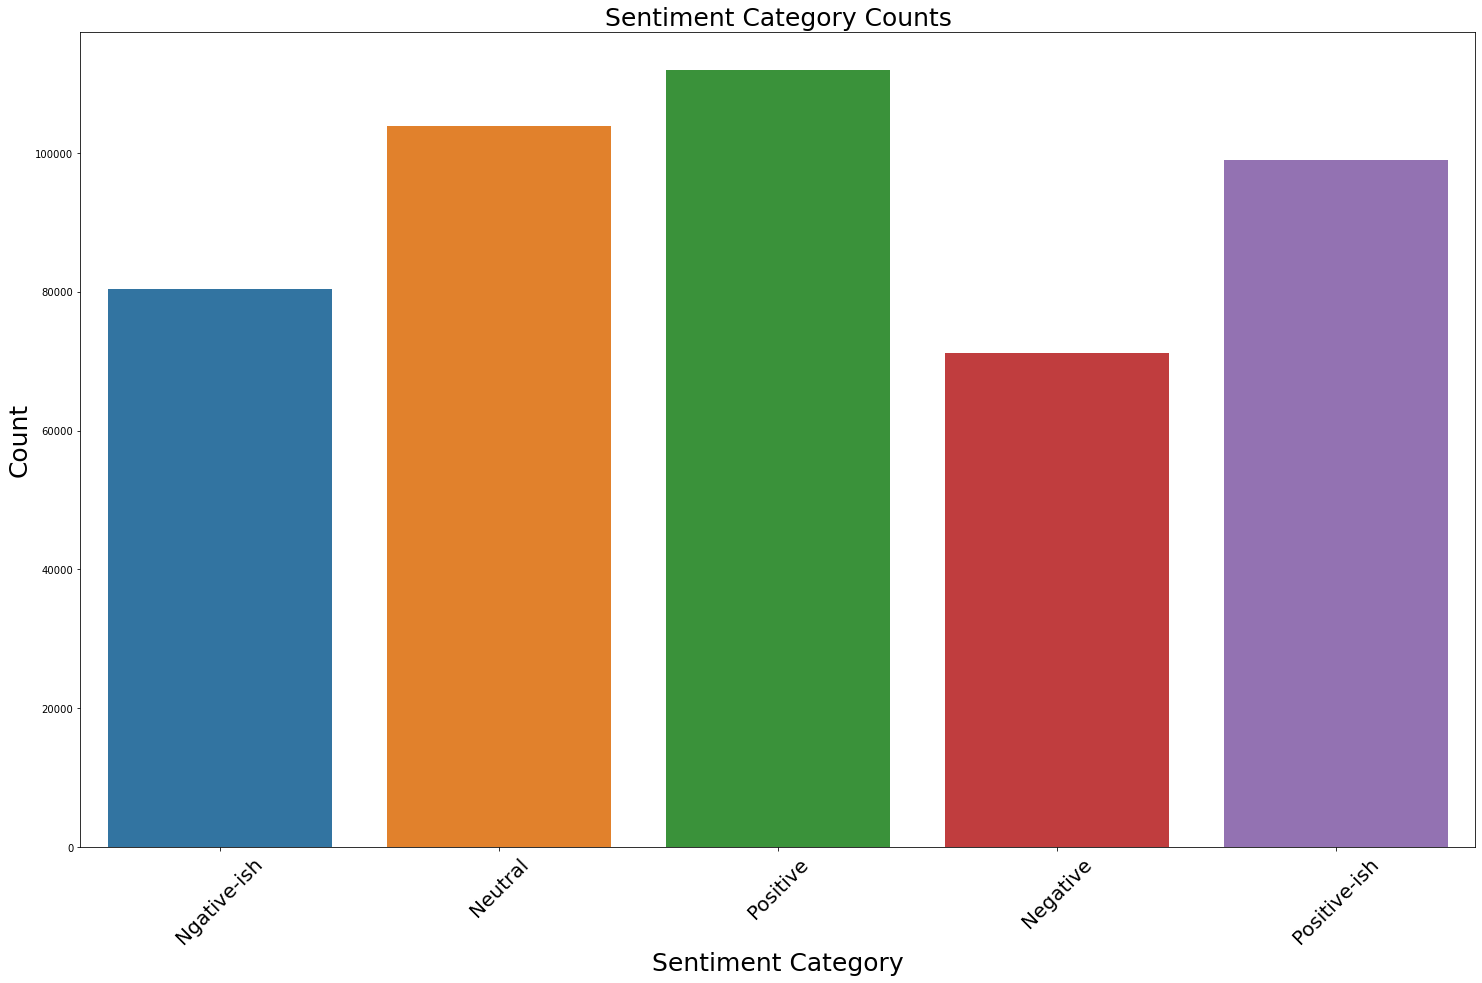

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the count of each sentiment category
sentiment_counts = refugee.groupBy('Sentiment_Category').count().toPandas()

# Set the color palette for the plot

# Create the bar plot
sns.barplot(data=sentiment_counts, x='Sentiment_Category', y='count')

# Set the title and labels
plt.title('Sentiment Category Counts', fontsize = 25)
plt.xlabel('Sentiment Category', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

# Rotate the x-axis labels if needed
plt.xticks(rotation=45, fontsize = 20)

# Display the plot
plt.show()

2023-05-24 22:59:49,204 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 22:59:49,284 WARN memory.MemoryStore: Not enough space to cache rdd_38_10 in memory! (computed 3.8 MiB so far)
2023-05-24 22:59:49,323 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,362 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,362 WARN memory.MemoryStore: Not enough space to cache rdd_38_16 in memory! (computed 23.7 MiB so far)
2023-05-24 22:59:49,363 WARN memory.MemoryStore: Not enough space to cache rdd_38_12 in memory! (computed 28.6 MiB so far)
2023-05-24 22:59:49,746 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 22:59:49,827 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 22:59:49,8

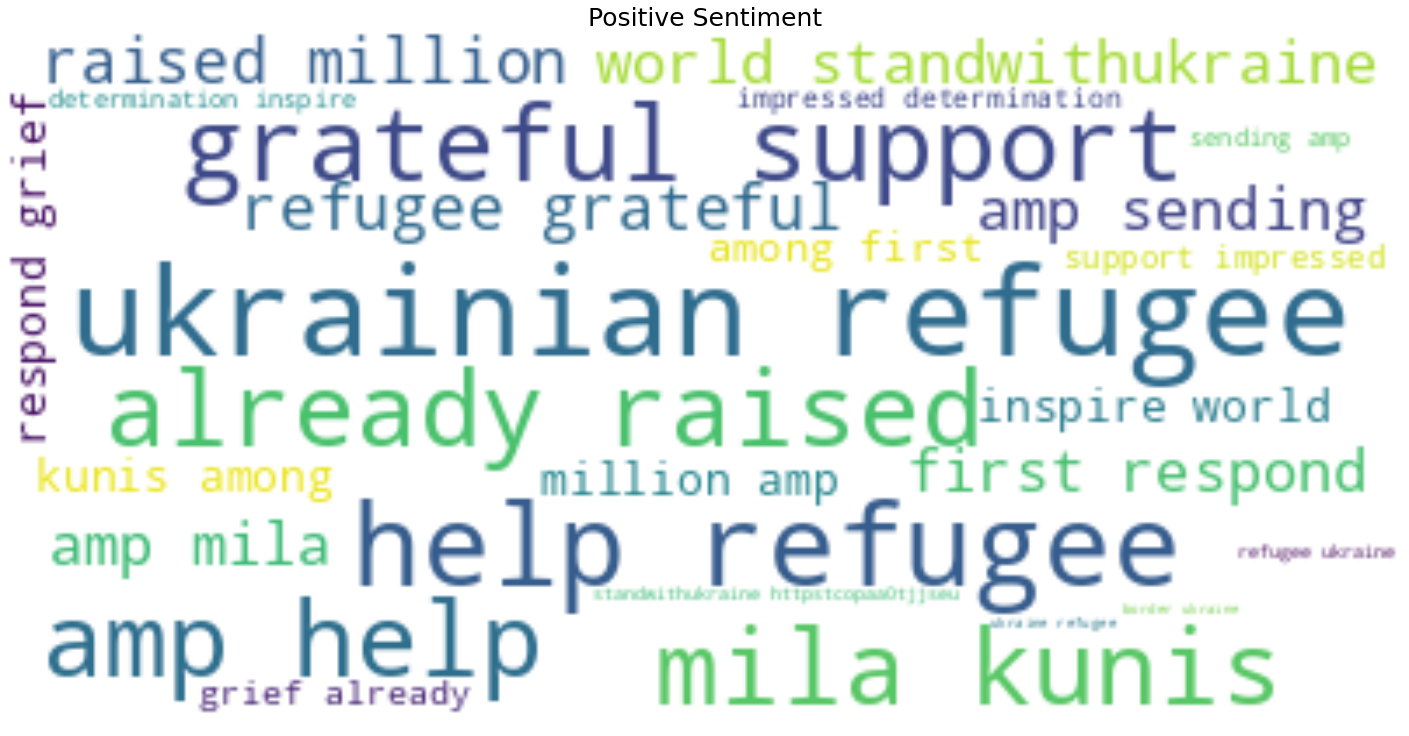

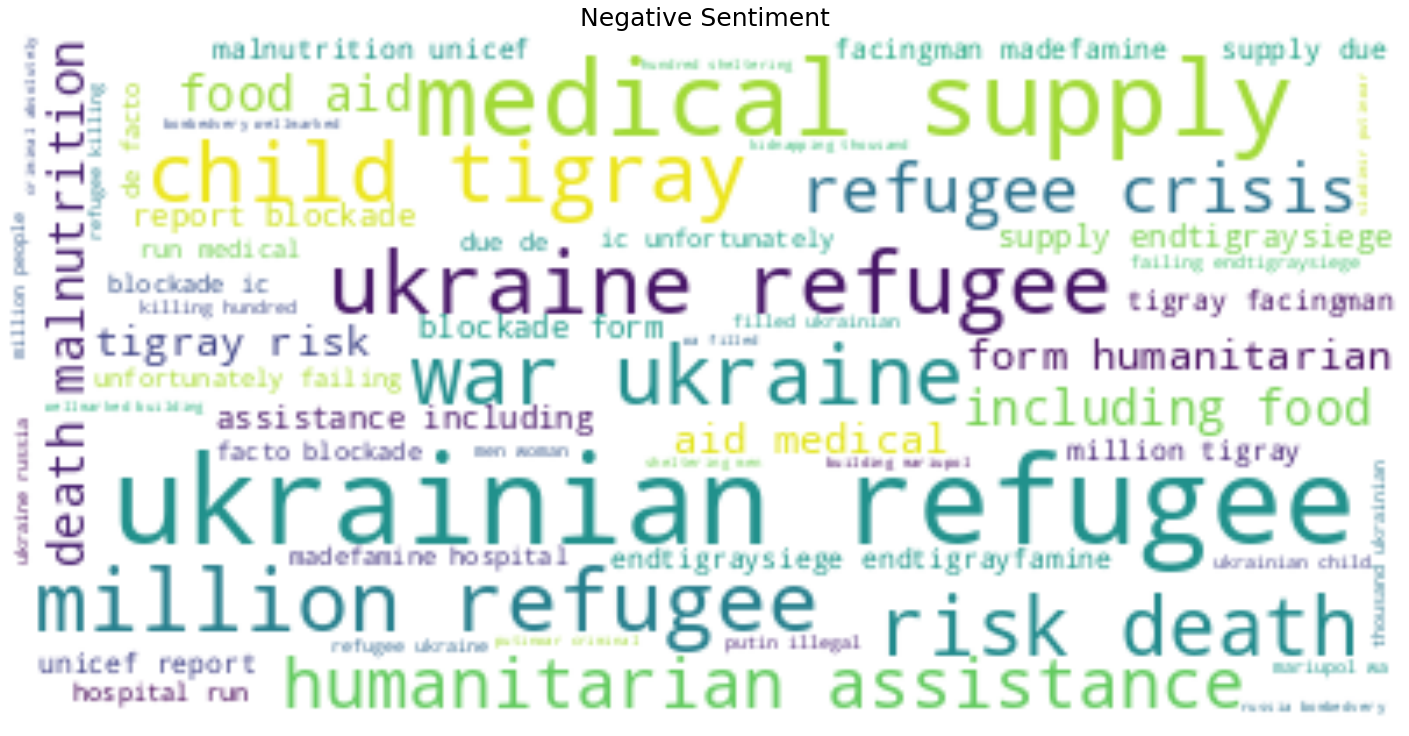

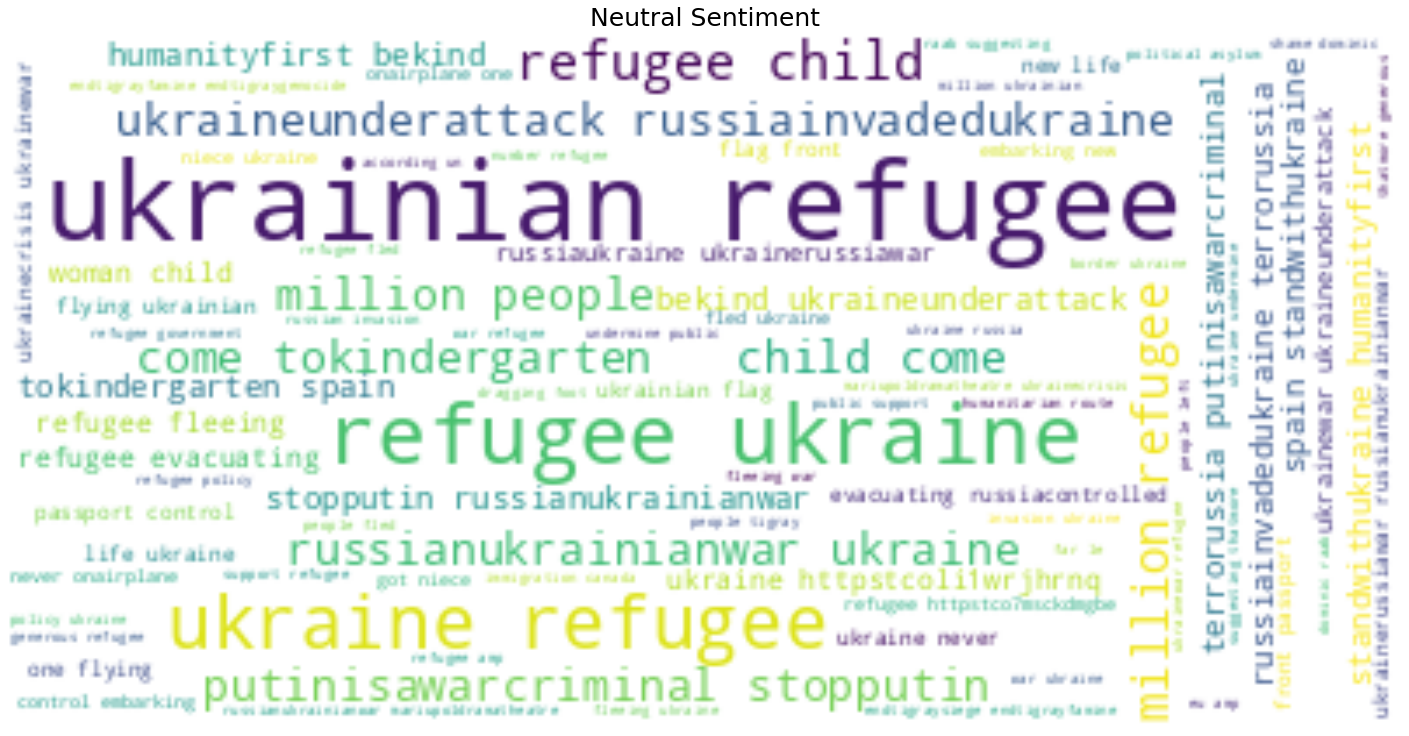

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import concat_ws

# Filter the DataFrame for positive sentiment
positive_df = refugee.filter(refugee['Sentiment_Category'] == 'Positive')
positive_text = ' '.join(positive_df.select(concat_ws(" ", positive_df['text'])).rdd.flatMap(lambda x: x).collect())

# Filter the DataFrame for negative sentiment
negative_df = refugee.filter(refugee['Sentiment_Category'] == 'Negative')
negative_text = ' '.join(negative_df.select(concat_ws(" ", negative_df['text'])).rdd.flatMap(lambda x: x).collect())

# Filter the DataFrame for neutral sentiment
neutral_df = refugee.filter(refugee['Sentiment_Category'] == 'Neutral')
neutral_text = ' '.join(neutral_df.select(concat_ws(" ", neutral_df['text'])).rdd.flatMap(lambda x: x).collect())

# Create word cloud for positive sentiment
positive_wordcloud = WordCloud(background_color='white').generate(positive_text)
plt.figure()
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment', fontsize = 25)
plt.axis('off')

# Create word cloud for negative sentiment
negative_wordcloud = WordCloud(background_color='white').generate(negative_text)
plt.figure()
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment', fontsize = 25)
plt.axis('off')

# Create word cloud for neutral sentiment
neutral_wordcloud = WordCloud(background_color='white').generate(neutral_text)
plt.figure()
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment', fontsize = 25)
plt.axis('off')

# Display the word clouds
plt.show()


2023-05-24 23:21:17,901 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 23:21:18,065 WARN memory.MemoryStore: Not enough space to cache rdd_38_11 in memory! (computed 27.3 MiB so far)
2023-05-24 23:21:18,066 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:18,269 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:18,309 WARN memory.MemoryStore: Not enough space to cache rdd_38_18 in memory! (computed 17.0 MiB so far)
2023-05-24 23:21:18,529 WARN memory.MemoryStore: Not enough space to cache rdd_38_17 in memory! (computed 25.0 MiB so far)


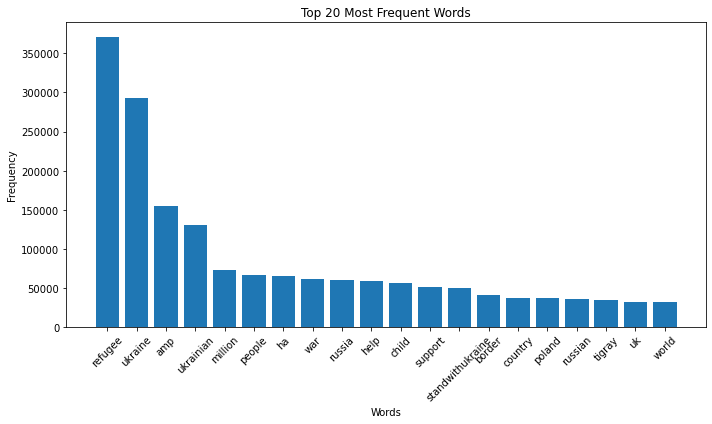

2023-05-24 23:21:22,982 WARN memory.MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 32.3 MiB so far)
2023-05-24 23:21:23,082 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:23,108 WARN memory.MemoryStore: Not enough space to cache rdd_38_11 in memory! (computed 3.8 MiB so far)
2023-05-24 23:21:23,130 WARN memory.MemoryStore: Not enough space to cache rdd_38_18 in memory! (computed 3.8 MiB so far)
2023-05-24 23:21:23,131 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 28.5 MiB so far)
2023-05-24 23:21:23,132 WARN memory.MemoryStore: Not enough space to cache rdd_38_17 in memory! (computed 3.8 MiB so far)


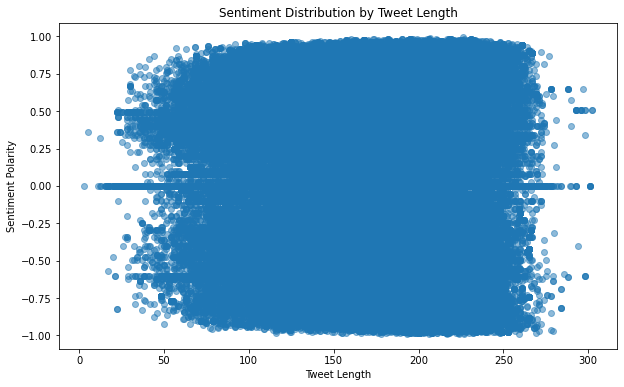

In [66]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from pyspark.sql.functions import length
from pyspark.sql.functions import col

# Word Frequency Analysis (Task 4)
# Convert the 'text' column to a single string
text_data = ' '.join(refugee.select('text').rdd.flatMap(lambda x: x).collect())

# Generate word frequency counts
word_counts = spark.createDataFrame([(word, count) for word, count in Counter(text_data.split()).items()], ['word', 'count'])

# Plot the top 20 most frequent words
top_words = word_counts.orderBy(col('count').desc()).limit(20).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top_words['word'], top_words['count'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sentiment and Tweet Length Analysis (Task 8)
# Calculate the length of each tweet
refugee = refugee.withColumn('tweet_length', length(refugee['text']))

# Convert PySpark DataFrame to Pandas for plotting
refugee_pd = refugee.select('tweet_length', 'sentiment_polarity').toPandas()

# Plot sentiment distribution based on tweet length
plt.figure(figsize=(10, 6))
plt.scatter(refugee_pd['tweet_length'], refugee_pd['sentiment_polarity'], alpha=0.5)
plt.xlabel('Tweet Length')
plt.ylabel('Sentiment Polarity')
plt.title('Sentiment Distribution by Tweet Length')
plt.show()


In [55]:
del sentiment_counts

NameError: name 'sentiment_counts' is not defined

2023-05-24 22:30:20,880 WARN memory.MemoryStore: Not enough space to cache rdd_38_8 in memory! (computed 28.5 MiB so far)
2023-05-24 22:30:21,003 WARN memory.MemoryStore: Not enough space to cache rdd_38_10 in memory! (computed 33.1 MiB so far)
2023-05-24 22:30:21,010 WARN memory.MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_38_14 in memory.
2023-05-24 22:30:21,028 WARN memory.MemoryStore: Not enough space to cache rdd_38_12 in memory! (computed 28.6 MiB so far)
2023-05-24 22:30:21,029 WARN memory.MemoryStore: Not enough space to cache rdd_38_14 in memory! (computed 384.0 B so far)
2023-05-24 22:30:21,065 WARN memory.MemoryStore: Not enough space to cache rdd_38_15 in memory! (computed 23.0 MiB so far)
2023-05-24 22:30:21,131 WARN memory.MemoryStore: Not enough space to cache rdd_38_20 in memory! (computed 27.5 MiB so far)


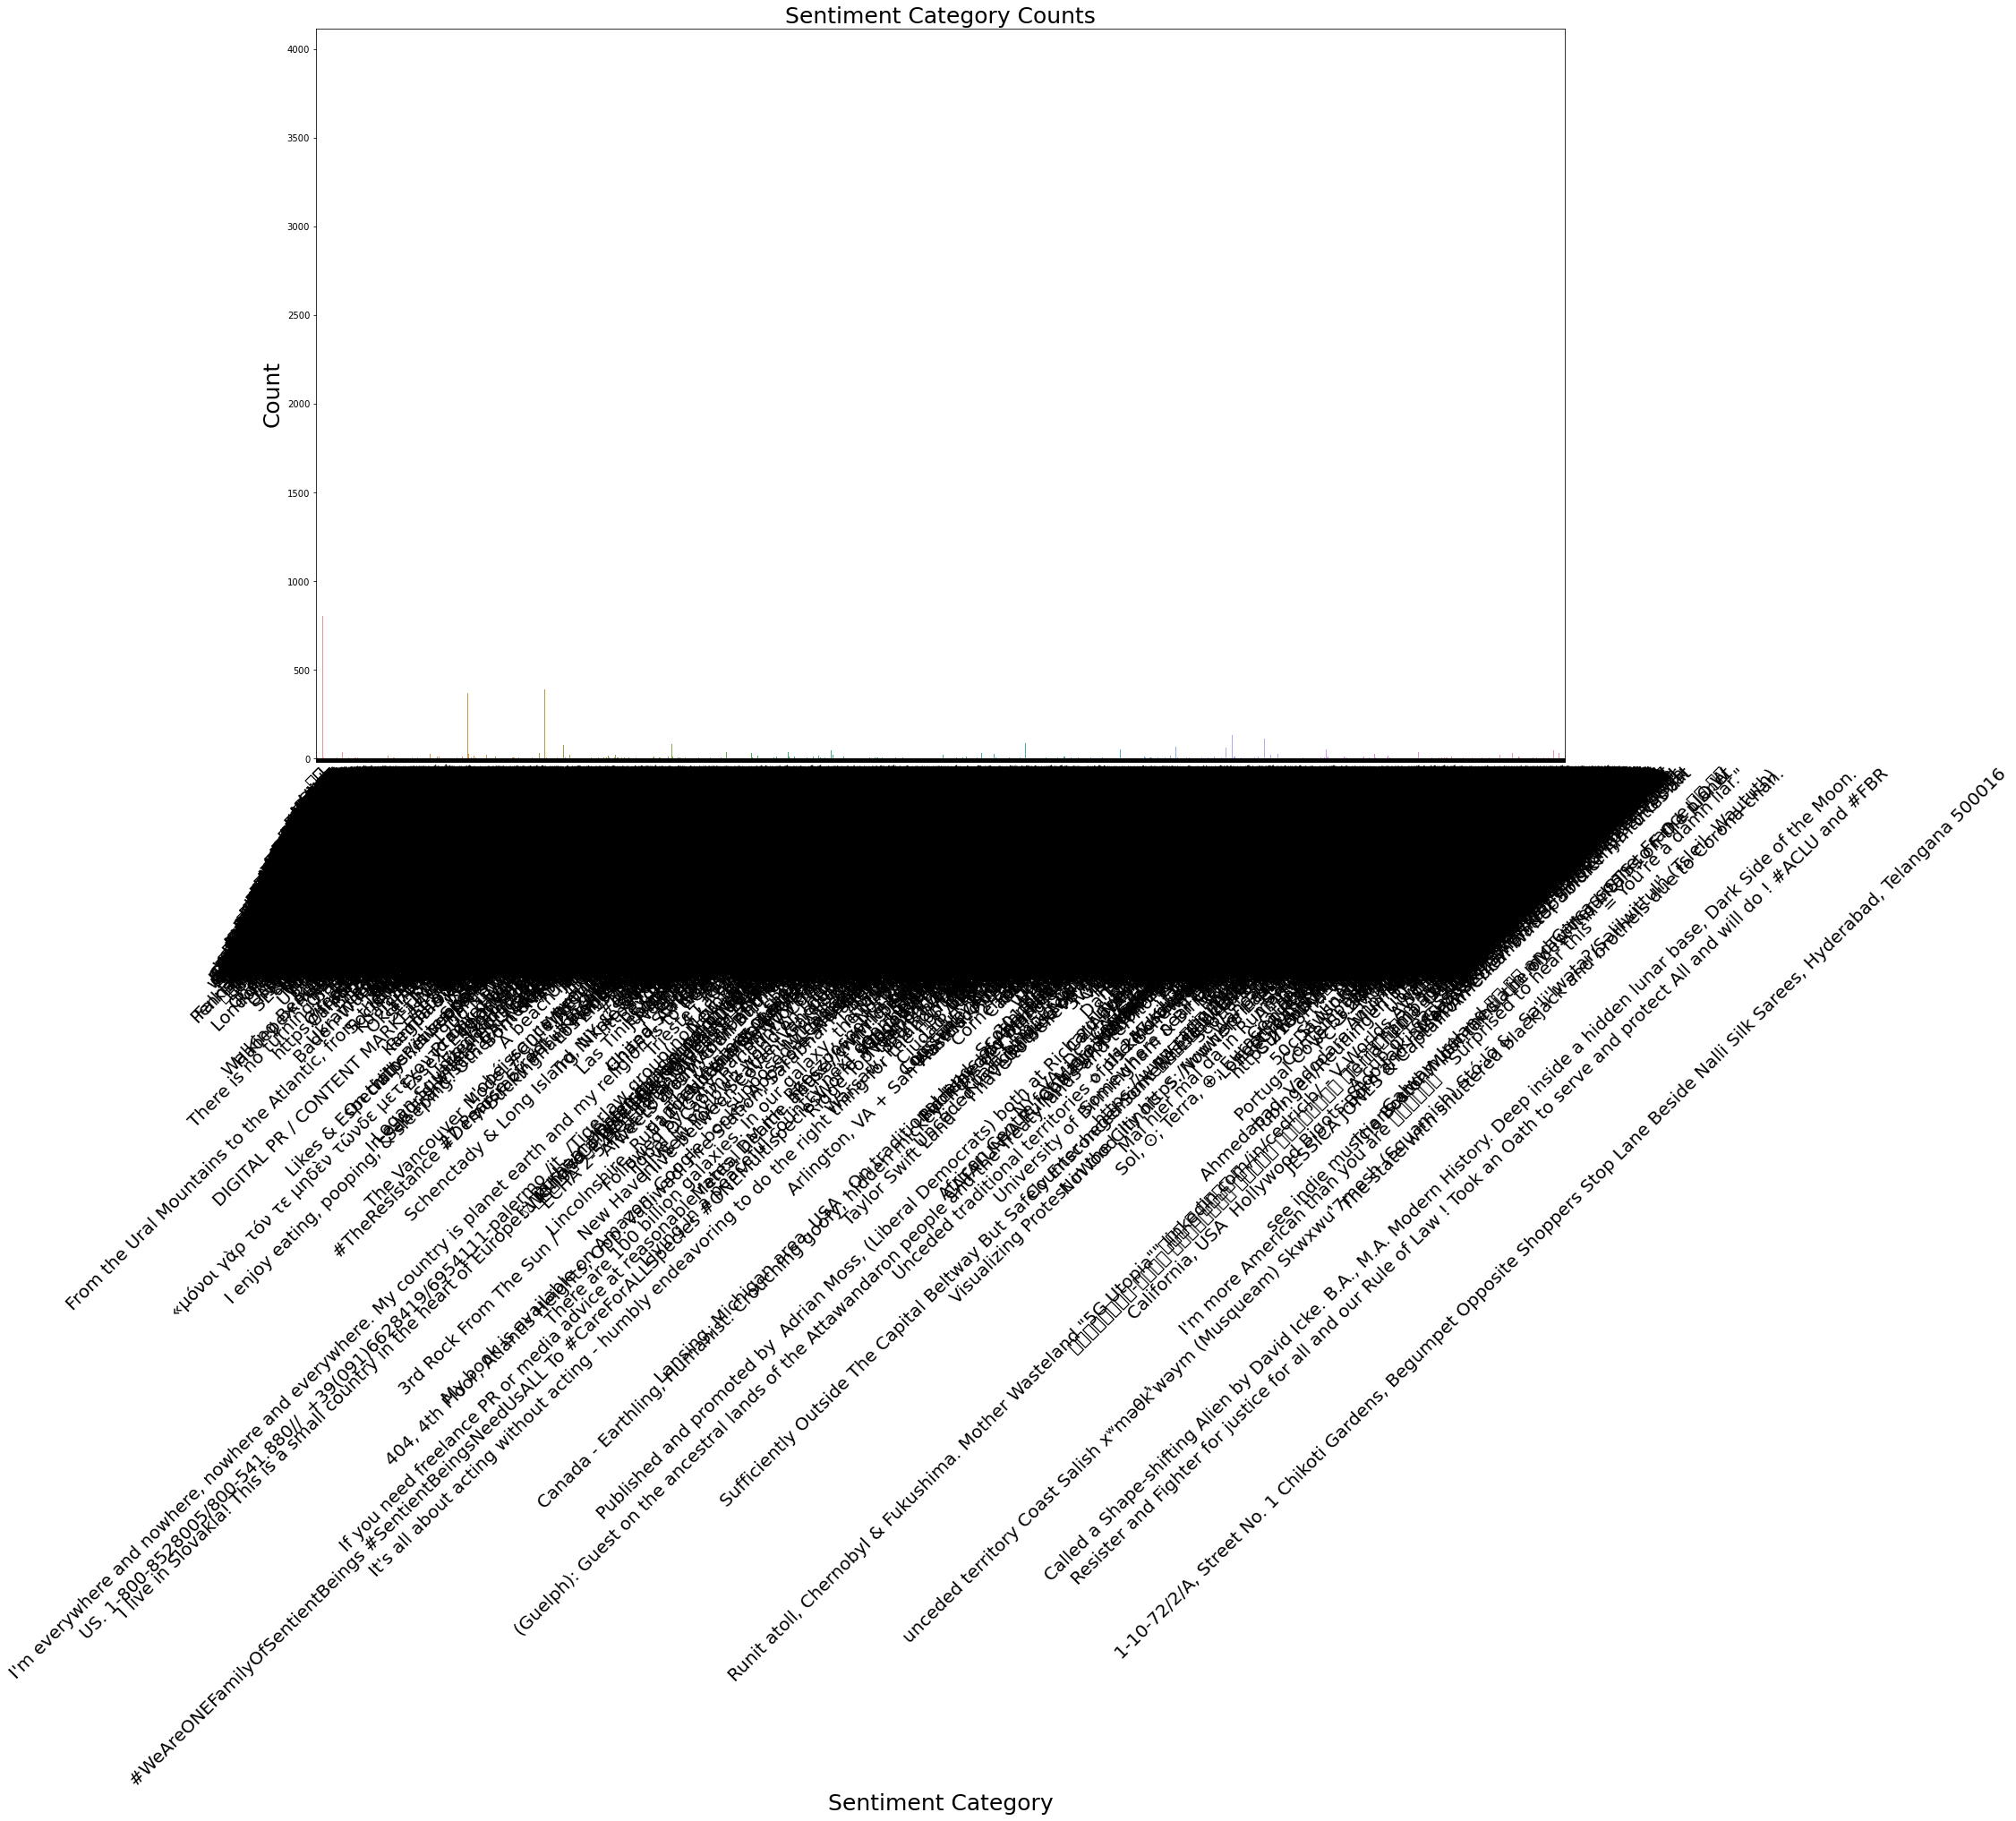

In [56]:
location_counts = refugee.groupBy('location').count().toPandas()


# Create the bar plot
sns.barplot(data=location_counts, x='location', y='count')

# Set the title and labels
plt.title('Sentiment Category Counts', fontsize = 25)
plt.xlabel('Sentiment Category', fontsize = 25)
plt.ylabel('Count', fontsize = 25)

# Rotate the x-axis labels if needed
plt.xticks(rotation=45, fontsize = 20)

# Display the plot
plt.show()

In [59]:
location_counts.shape

(56707, 2)

In [17]:
from pyspark.sql.functions import avg, date_format

timeseries = refugee.withColumn('date', date_format('tweetcreatedts', 'yyyy-MM-dd'))
timeseries = timeseries.withColumn('hour', date_format('tweetcreatedts', 'HH'))
timeseries = timeseries.select('date', 'hour', 'sentiment_polarity')


In [18]:
timeseries = timeseries.groupBy('date', 'hour').agg(avg('sentiment_polarity').alias('hourly_polarity'))
#timeseries = timeseries.orderBy(col('date'), col('hour'))
#timeseries = spark.sql('select date, hour, avg(sentiment_polarity) from timeseries group by date, hour')

In [19]:
#timeseries.persist()
#timeseries.show(20)

KeyboardInterrupt: 

In [20]:
timeseries = timeseries.orderBy(col('date'), col('hour'))


In [21]:
timeseries = timeseries.filter(timeseries.date != '1970-01-01')

In [25]:
#timeseries_df = timeseries.toPandas()
#timeseries_df.shape
timeseries_df = pd.read_csv('Timeseries_Data.csv')
timeseries_df.head()

Unnamed: 0        date  hour  hourly_polarity      datetime  polarity_diff
0           1  2022-02-24     7         0.023769  2022-02-2407       0.298069
1           2  2022-02-24     8         0.151148  2022-02-2408       0.127379
2           3  2022-02-24     9         0.056736  2022-02-2409      -0.094411
3           4  2022-02-24    10         0.411610  2022-02-2410       0.354874
4           5  2022-02-24    11         0.406074  2022-02-2411      -0.005536

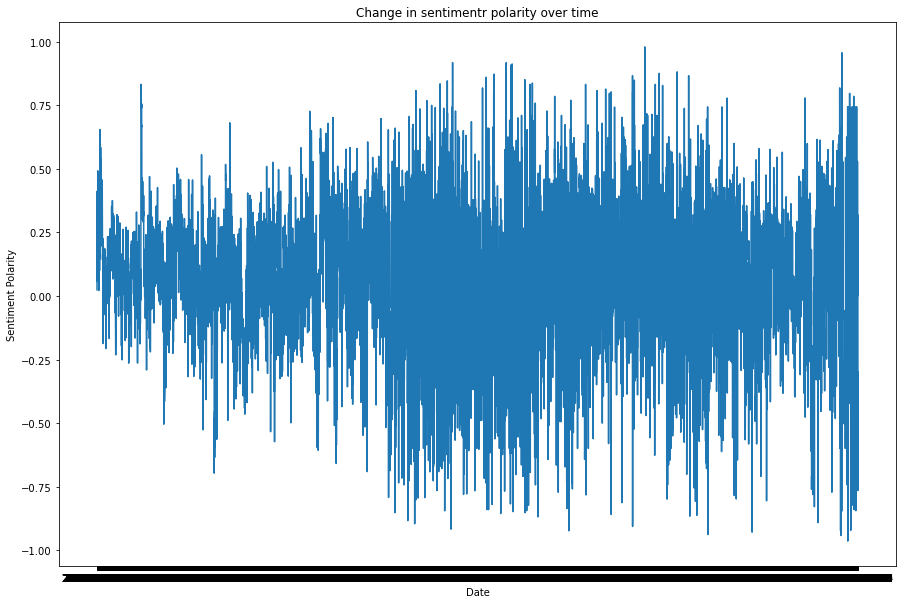

In [27]:
#plotting the polarity asd a function of time
import seaborn as sns
import matplotlib.pyplot as plt
#timeseries_df['datetime'] = timeseries_df['date'] + timeseries_df['hour']

plt.figure(figsize=(15, 10))

sns.lineplot(data = timeseries_df, x = 'datetime', y = 'hourly_polarity')
plt.xlabel('Date')
plt.ylabel('Sentiment Polarity')
plt.title('Change in sentimentr polarity over time')
plt.show()

The period of the signal is 3398.9999999999995 hours
5099
5097


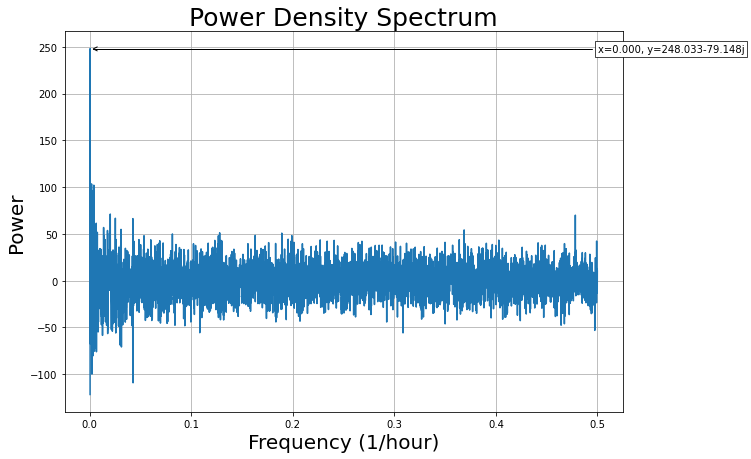

In [28]:
#find the period of any seasonality in my data using a fft method seen in my last ca, this is needed to find out what period value to use in seasonal decompose
import numpy as np

def seasonality(series, mult):
    #extracting the data from the spark dataframe
    rain = series

    #using the fourier transform to find the period of the signal
    rain_fft = np.fft.rfft(rain)*mult
    rain_frequency = np.fft.rfftfreq(len(rain))

    #code to find max value and annotate the plot "https://stackoverflow.com/questions/10366520/matplotlib-annotate-a-point-with-maximum-y-value" Code used from here, no need to re-invent the wheel
    def annot_max(x,y, ax=None):
        xmax = x[np.argmax(y)]
        ymax = y.max()
        text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
        if not ax:
            ax=plt.gca()
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
        kw = dict(xycoords='data',textcoords="data",
                  arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.5,ymax+5), **kw)
        print(f'The period of the signal is {1/(xmax)} hours') 

    #plotting the data
    plt.figure(figsize=(10, 7))
    plt.plot(rain_frequency[2:], rain_fft[2: ])
    annot_max(rain_frequency[2:], rain_fft[2: ])
    print(len(rain_frequency))
    print(len(rain_frequency[2:]))
    plt.xlabel('Frequency (1/hour)', fontsize = 20)
    plt.ylabel('Power', fontsize = 20)
    plt.title('Power Density Spectrum', fontsize = 25)
    plt.grid()
    plt.show()

seasonality(timeseries_df['hourly_polarity'], 1)

There is a period of 3400 hours or 141.66 days

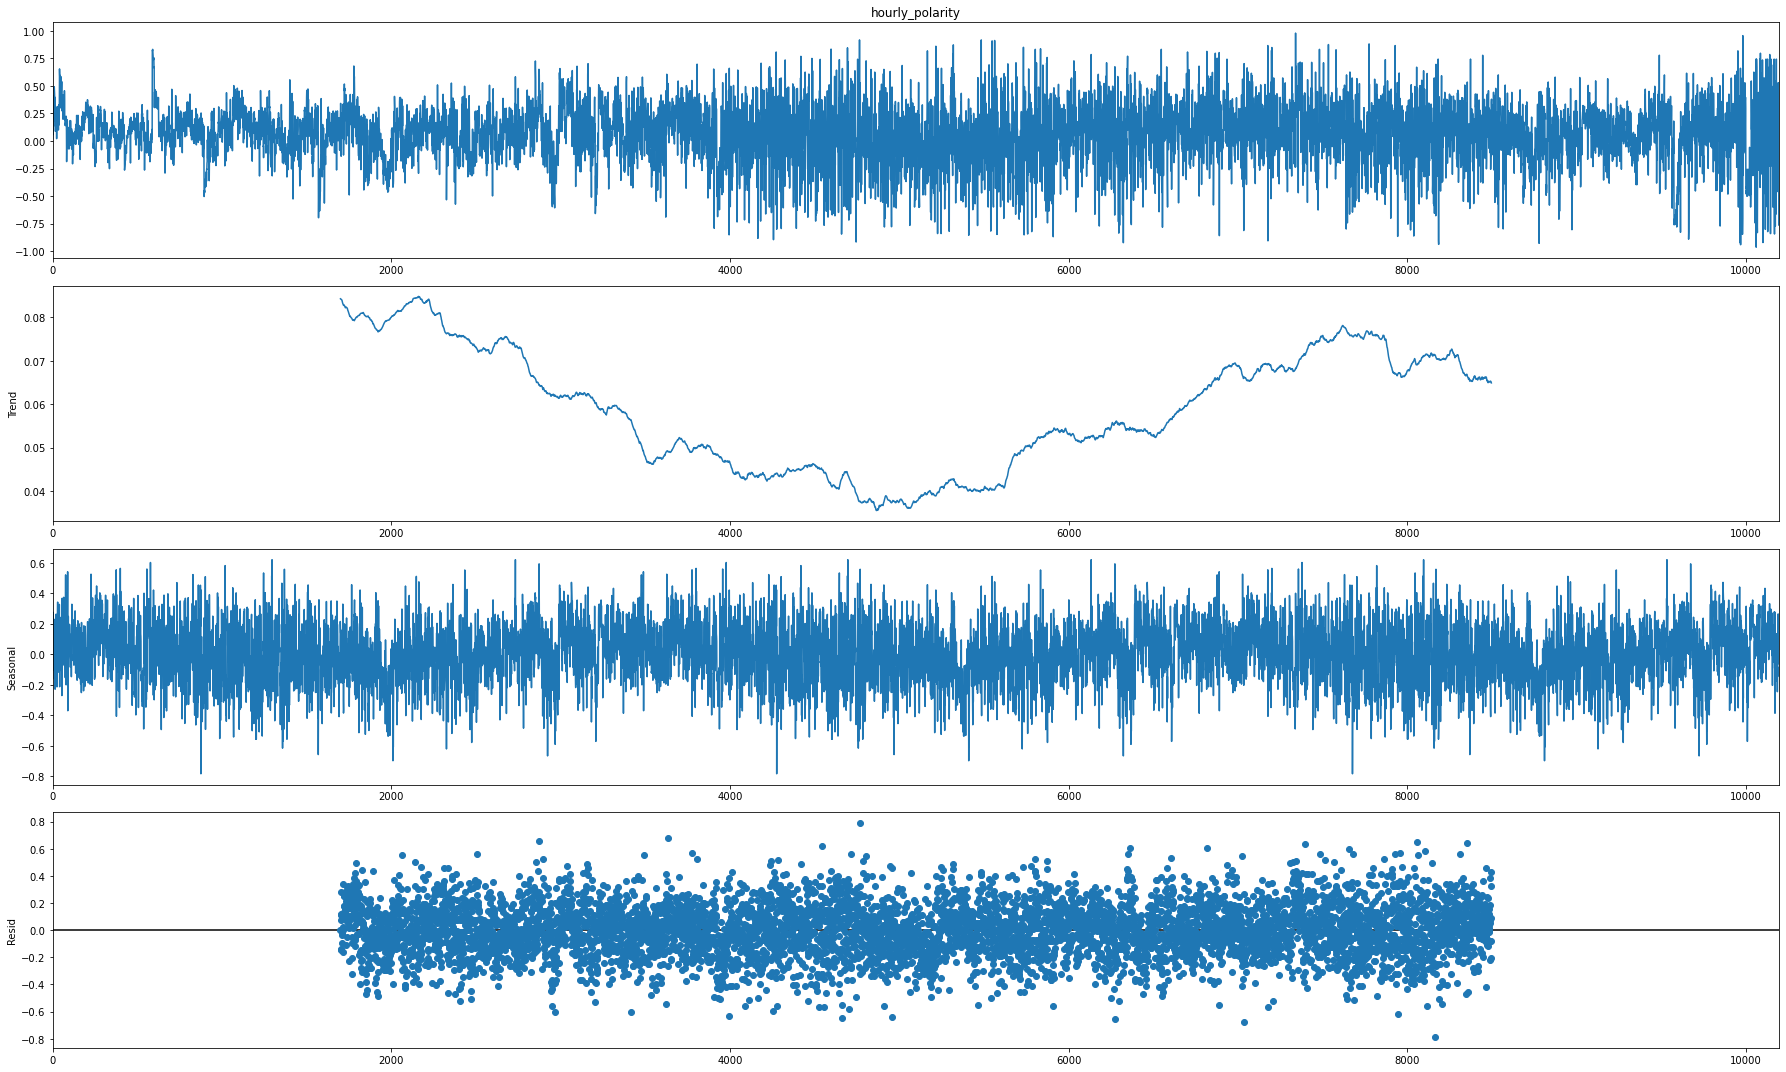

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (25,15)
result = seasonal_decompose(timeseries_df['hourly_polarity'], model='additive', period = 3400)
result.plot()
plt.show()



In [30]:
#there is no noticable seasonality in the data, we will double check this using the ADF
#there is a prominent trend over time

In [31]:
from statsmodels.tsa.stattools import kpss
result = kpss(timeseries_df['hourly_polarity'])
if result[1] > 0.05:
    print('the data is stationary')
if result[1] < 0.05:
    print('the data is not stationary')
    
print(result[1])


the data is not stationary
0.047785998341642724


In [32]:
#since this data is not stationary we will difference the data and try againb
timeseries_df['polarity_diff'] = timeseries_df['hourly_polarity'].diff()
timeseries_df = timeseries_df.iloc[1: , :]
timeseries_df.head()

Unnamed: 0        date  hour  hourly_polarity      datetime  polarity_diff
1           2  2022-02-24     8         0.151148  2022-02-2408       0.127379
2           3  2022-02-24     9         0.056736  2022-02-2409      -0.094411
3           4  2022-02-24    10         0.411610  2022-02-2410       0.354874
4           5  2022-02-24    11         0.406074  2022-02-2411      -0.005536
5           6  2022-02-24    12         0.131907  2022-02-2412      -0.274167

In [33]:
result = kpss(timeseries_df['polarity_diff'])
if result[1] > 0.05:
    print('the data is stationary')
if result[1] < 0.05:
    print('the data is not stationary')
    
print(result[1])

the data is stationary
0.1


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


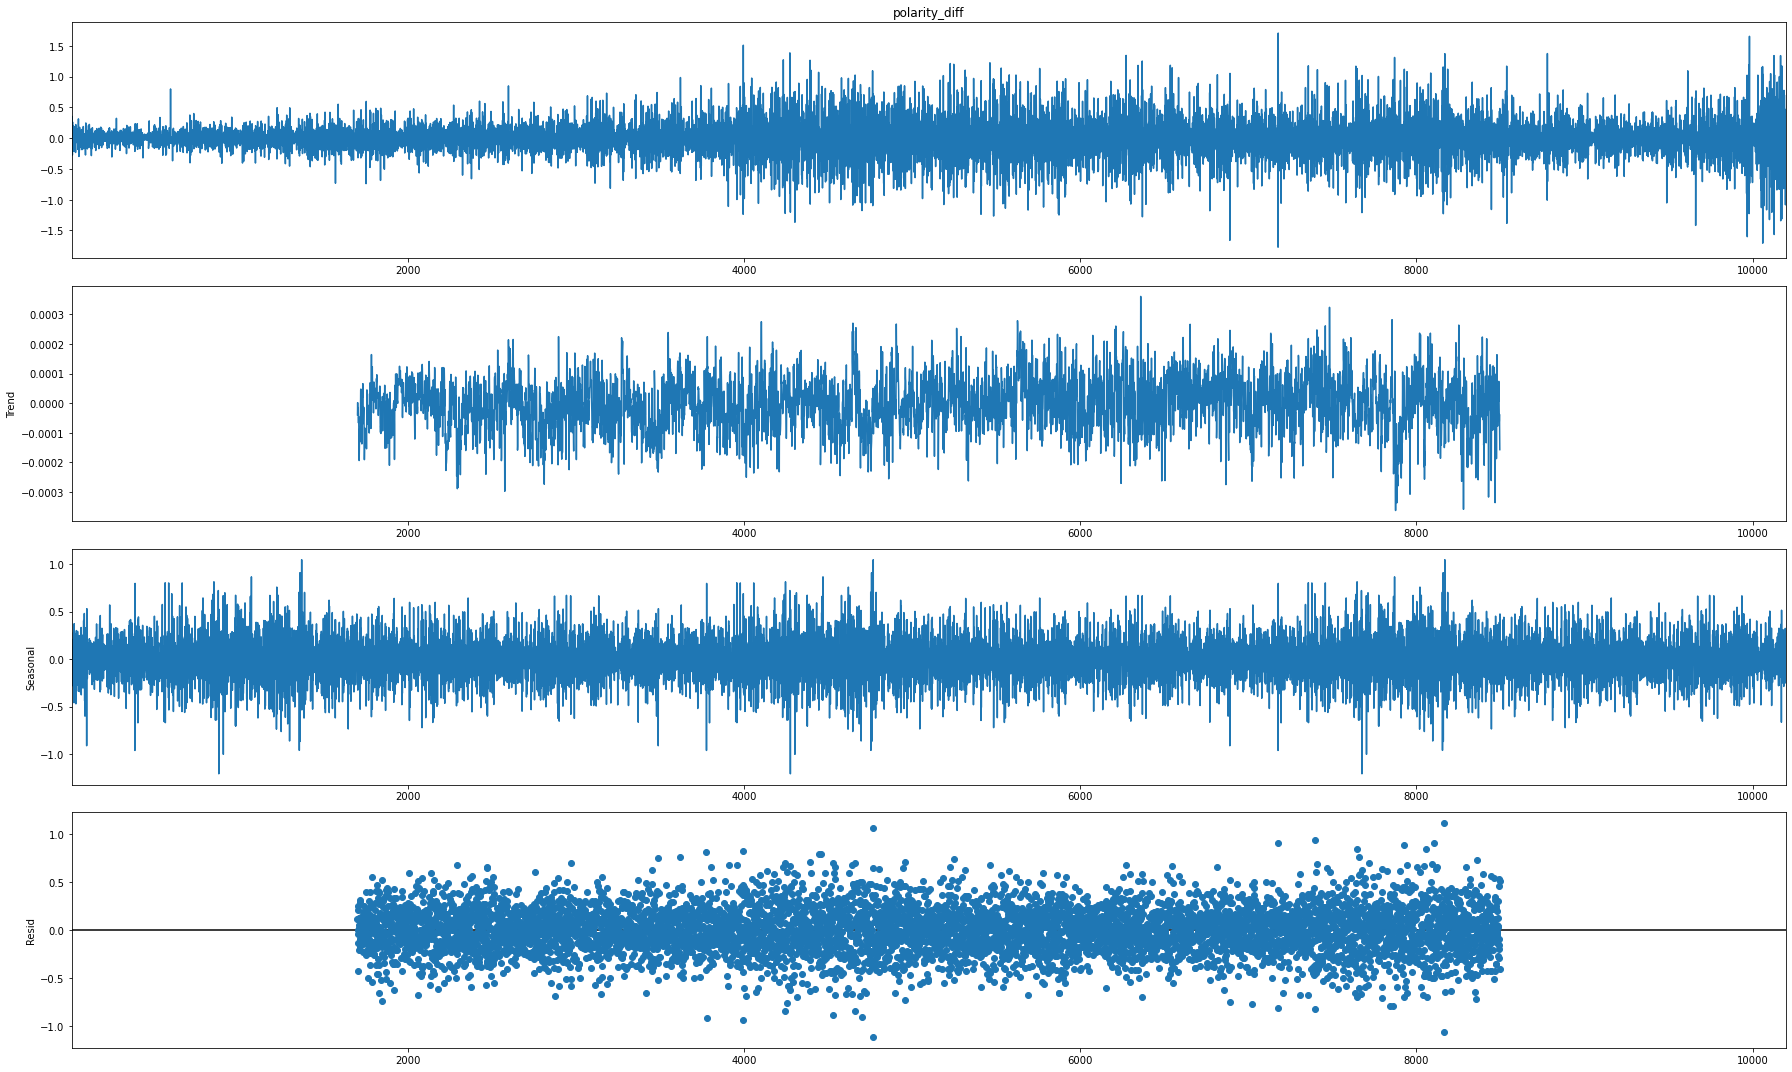

In [34]:
plt.rcParams['figure.figsize'] = (25,15)
result = seasonal_decompose(timeseries_df['polarity_diff'], model='additive', period = 3400)
result.plot()
plt.show()

#great the non-stationarity is gone



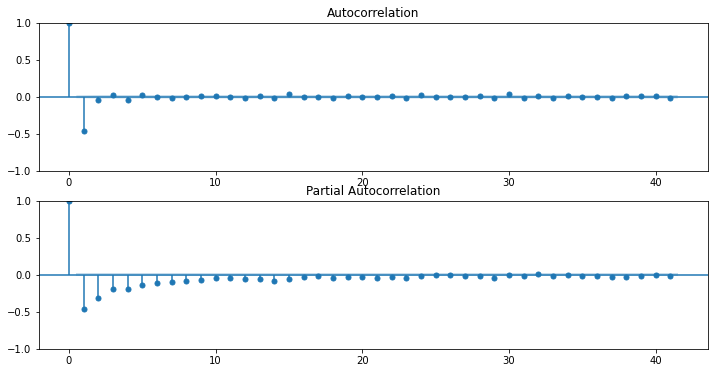

In [35]:
#programminbg a brute force gridsearch style method to finding opt parameters for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df and 'column_name' is the name of the column containing your time series data
data = timeseries_df['polarity_diff']

fig, ax = plt.subplots(2, figsize=(12,6))

# Plot ACF
plot_acf(data, ax=ax[0])

# Plot PACF
plot_pacf(data, ax=ax[1])

plt.show()



p = 1
q = 2
d = 1(first order differencing)

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast = SARIMAX(timeseries_df['hourly_polarity'], order = (1,1,2), seasonal_order = (1,1,2,6))#chose 6 for half year period(nearly)
forecast_fit = forecast.fit()
forecast_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77251D-01    |proj g|=  4.09264D-01

At iterate    5    f=  3.20428D-02    |proj g|=  1.52963D-01

At iterate   10    f=  1.66755D-02    |proj g|=  7.48793D-02

At iterate   15    f=  3.24882D-03    |proj g|=  7.43327D-02

At iterate   20    f=  1.66259D-03    |proj g|=  1.43877D-02

At iterate   25    f=  1.52774D-03    |proj g|=  8.52446D-03

At iterate   30    f=  4.88548D-04    |proj g|=  3.29105D-02

At iterate   35    f= -2.46502D-03    |proj g|=  4.77866D-02

At iterate   40    f= -4.06312D-03    |proj g|=  1.69308D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   hourly_polarity   No. Observations:                10196
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 6)   Log Likelihood                  41.428
Date:                           Wed, 24 May 2023   AIC                            -68.855
Time:                                   21:50:09   BIC                            -18.252
Sample:                                        0   HQIC                           -51.742
                                         - 10196                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7731      0.025     31.323      0.000       0.725       0.821
ma.L1         -1.5911      0.028    -57.034      0.000      -1.646      -1.536
ma.L2          0.6029      0.026     22.985      0.000       0.551       0.654
ar.S.L6       -1.0000      0.374     -2.671      0.008      -1.734      -0.266
ma.S.L6    -2.558e-05      0.085     -0.000      1.000      -0.166       0.166
ma.S.L12      -1.0000      0.664     -1.507      0.132      -2.301       0.301
sigma2         0.0580      0.017      3.452      0.001       0.025       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):              1519.36
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(-5.0, 5.0)

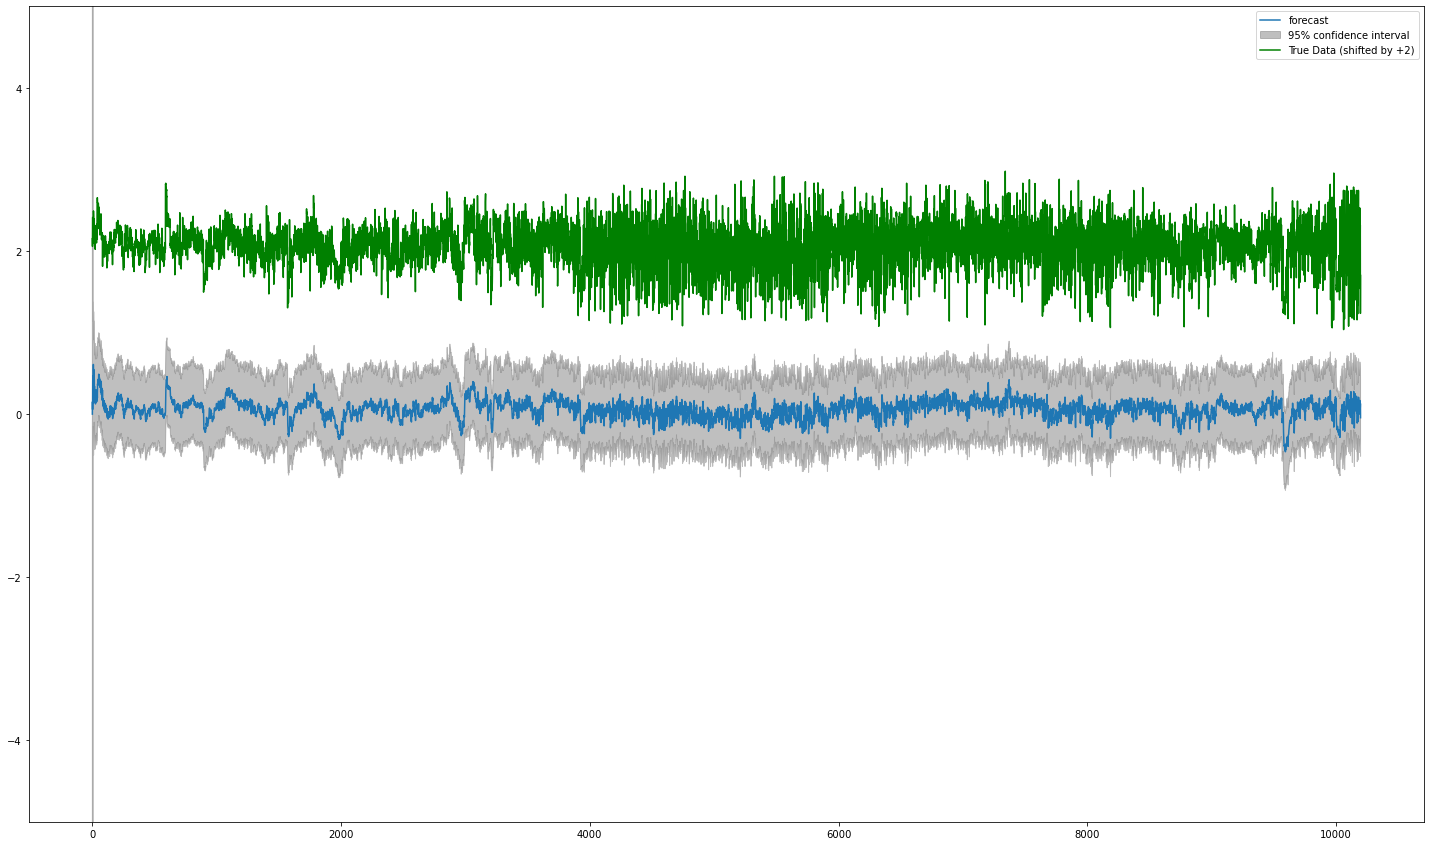

In [40]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(forecast_fit)
plt.plot(timeseries_df['hourly_polarity']+2, color = 'green', label = 'True Data (shifted by +2)')

plt.legend()
plt.ylim(-5,5)


In [41]:
forecast_1_week = forecast_fit.forecast(steps=7*24)
forecast_1_month = forecast_fit.forecast(steps=28*24)
forecast_3_month = forecast_fit.forecast(steps=28*3*24)



In [42]:
print(forecast_1_week)

10197   -0.065610
10198   -0.047866
10199   -0.020377
10200   -0.016879
10201   -0.001380
           ...   
10360    0.028138
10361    0.037508
10362    0.027076
10363    0.031789
10364    0.028859
Name: predicted_mean, Length: 168, dtype: float64


[]

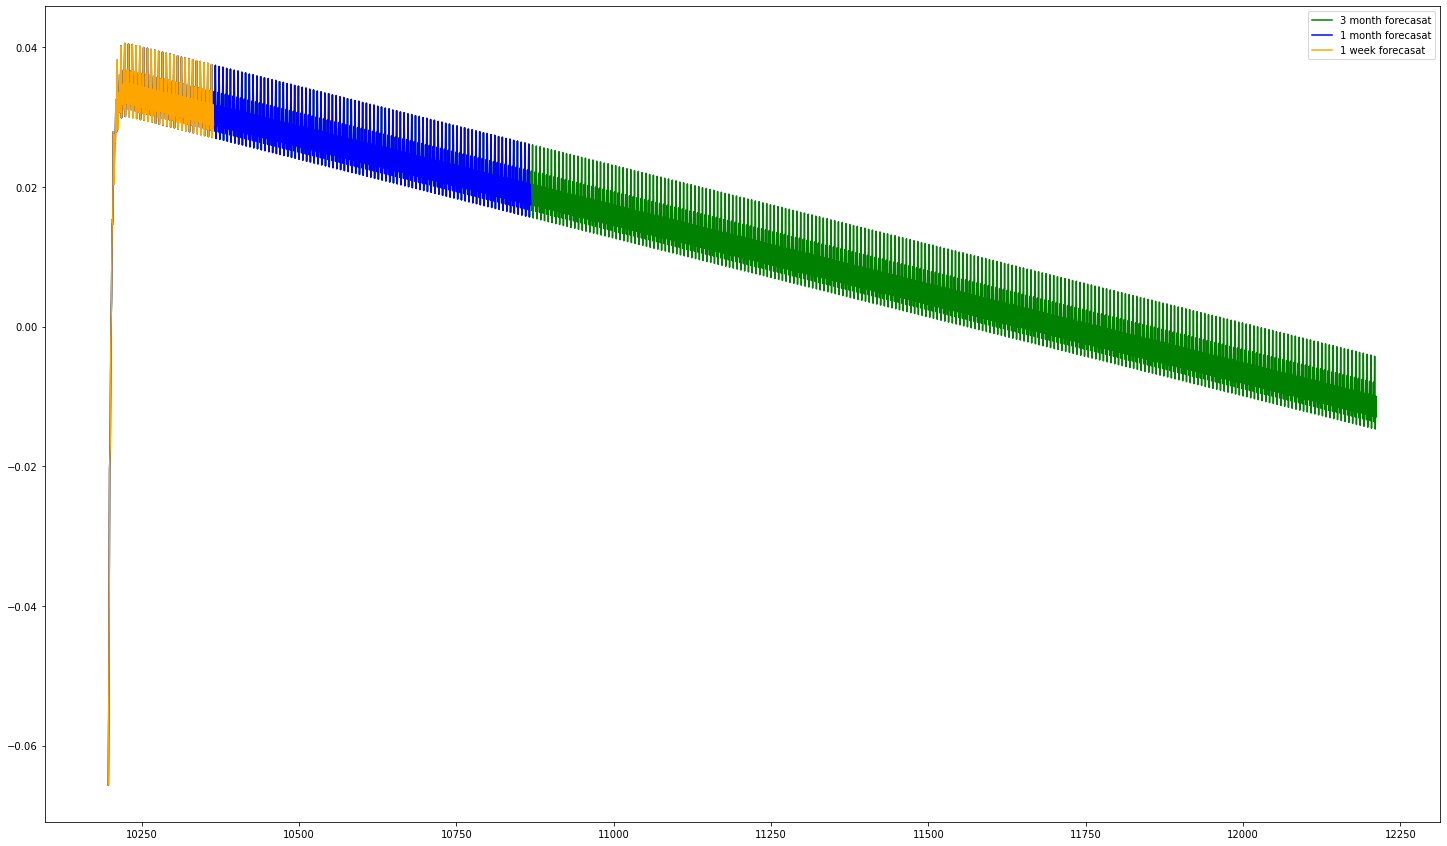

In [47]:
plt.plot(forecast_3_month, label = '3 month forecasat', color = 'green')
plt.plot(forecast_1_month, label = '1 month forecasat', color = 'blue')
plt.plot(forecast_1_week, label = '1 week forecasat', color = 'orange')

plt.legend()
plt.plot()

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
timeseries_df = pd.read_csv('Timeseries_Data.csv')

In [ ]:
#using auto_arima to fit timeseries

import numpy as np
import pmdarima as pm